In [1]:
# necessary imports
import nltk
from nltk.corpus import treebank, brown, conll2000
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint

It's difficult to find free sequence labelling datasets because they're so labour-intensive to create.
<br><br>
Fortunately, **Natural Language Toolkit (NLTK)** includes enough free sets of labelled corpora for our purposes. NLTK also provides them in a convenient uniform format.<br>
https://www.nltk.org/index.html<br>
https://www.nltk.org/nltk_data/<br>
<br>
We'll use the Treebank, Brown, and CONLL-2000 datasets. 

In [2]:
nltk.download('treebank')
nltk.download('brown')
nltk.download('conll2000')

[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Unzipping corpora/treebank.zip.
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.


True

In their original form, the datasets use different part-of-speech (PoS) tag sets. We need to ensure they all use the same tagset, so we'll download a simplified set called the *universal_tagset* from NLTK.<br>

See Section 2.3 here for a list of tags: https://www.nltk.org/book/ch05.html

In [3]:
nltk.download('universal_tagset')

[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


True

In [4]:
# Download all PoS-tagged sentences and place them in one list.
tagged_sentences = treebank.tagged_sents(tagset='universal') +\
                   brown.tagged_sents(tagset='universal') +\
                   conll2000.tagged_sents(tagset='universal')

print(tagged_sentences[0])
print(f"Dataset size: {len(tagged_sentences)}")

[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')]
Dataset size: 72202


In [5]:
# separate the words from the tags 
sentences, sentence_tags = [], []

for s in tagged_sentences:
  sentence, tags = zip(*s)
  sentences.append(list(sentence))
  sentence_tags.append(list(tags))

print(len(sentences), len(sentence_tags))
print(sentences[0])
print(sentence_tags[0])

72202 72202
['Pierre', 'Vinken', ',', '61', 'years', 'old', ',', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'Nov.', '29', '.']
['NOUN', 'NOUN', '.', 'NUM', 'NOUN', 'ADJ', '.', 'VERB', 'VERB', 'DET', 'NOUN', 'ADP', 'DET', 'ADJ', 'NOUN', 'NOUN', 'NUM', '.']


In [6]:
# create train/validation/test splits
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(sentences, sentence_tags, test_size=0.25)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.4)


In [7]:
print(len(X_train), len(y_train))
print(len(X_val), len(y_val))
print(len(X_test), len(y_test))

54151 54151
10830 10830
7221 7221


In [8]:
# tokenize sentences
from tensorflow.keras.preprocessing.text import Tokenizer

sentence_tokenizer = Tokenizer(oov_token='<OOV>')
sentence_tokenizer.fit_on_texts(X_train)

X_train = sentence_tokenizer.texts_to_sequences(X_train)
X_val   = sentence_tokenizer.texts_to_sequences(X_val)

In [9]:
print(f"Vocabulary size: {len(sentence_tokenizer.word_index)}")

Vocabulary size: 52239


In [10]:
# tokenize tags
tag_tokenizer = Tokenizer()
tag_tokenizer.fit_on_texts(y_train)

y_train = tag_tokenizer.texts_to_sequences(y_train)
y_val   = tag_tokenizer.texts_to_sequences(y_val)

In [11]:
print(f"Number of PoS tags: {len(tag_tokenizer.word_index)}")

Number of PoS tags: 12


In [12]:
# max sentence length
print('Max:', max([len(x) for x in X_train]))
len(max(X_train, key=len))

Max: 271


271

In [13]:
# pad sequences & tags
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_train = pad_sequences(X_train, padding='post', maxlen=271)
X_val = pad_sequences(X_val, padding='post', maxlen=271)

y_train = pad_sequences(y_train, padding='post', maxlen=271)
y_val = pad_sequences(y_val, padding='post', maxlen=271)

In [14]:
# one hot encode tags
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

We can determine the PoS tag from a one-hot encoding by seeing which index is set to 1, then using that to query the tag tokenizer's index_word dictionary.

In [15]:
idx = np.argmax(y_train[0][0])
print(f"Index: {idx}")

print(f"Tag: {tag_tokenizer.index_word[idx]}")

Index: 5
Tag: det


# Bidirectional LSTM

In [16]:
len(tag_tokenizer.word_index)

12

In [17]:
# store configuration parameters
class CFG:
    SEED = 0
    NUM_TOKENS = len(sentence_tokenizer.word_index) + 1 # + padding
    NUM_CLASSES = len(tag_tokenizer.word_index) + 1 # + padding
    MAX_LENGTH = 271
    BATCH_SIZE = 256
    EMBEDDING_DIMS = 128
    EPOCHS = 20
    LSTM_DIMS = 128

In [18]:
import tensorflow as tf

tf.random.set_seed(CFG.SEED)

In [19]:
# model
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense

model = keras.Sequential([
    Embedding(input_dim=CFG.NUM_TOKENS, 
              output_dim=CFG.NUM_CLASSES, 
              input_length=CFG.MAX_LENGTH,
              mask_zero=True),
    Bidirectional(LSTM(CFG.LSTM_DIMS, return_sequences=True, 
                       kernel_initializer=tf.keras.initializers.random_normal(seed=1))),
    Dense(CFG.NUM_CLASSES, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 271, 13)           679120    
                                                                 
 bidirectional (Bidirectiona  (None, 271, 256)         145408    
 l)                                                              
                                                                 
 dense (Dense)               (None, 271, 13)           3341      
                                                                 
Total params: 827,869
Trainable params: 827,869
Non-trainable params: 0
_________________________________________________________________


In [20]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [21]:
es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

history = model.fit(X_train, y_train, epochs=CFG.EPOCHS, 
                    batch_size=CFG.EPOCHS, validation_data=(X_val, y_val), 
                    callbacks=[es])

Epoch 1/20
2708/2708 [==============================] - 95s 30ms/step - loss: 0.3158 - accuracy: 0.9015 - val_loss: 0.1155 - val_accuracy: 0.9615
Epoch 2/20
2708/2708 [==============================] - 52s 19ms/step - loss: 0.0845 - accuracy: 0.9722 - val_loss: 0.0943 - val_accuracy: 0.9683
Epoch 3/20
2708/2708 [==============================] - 49s 18ms/step - loss: 0.0600 - accuracy: 0.9805 - val_loss: 0.0892 - val_accuracy: 0.9704
Epoch 4/20
2708/2708 [==============================] - 49s 18ms/step - loss: 0.0472 - accuracy: 0.9846 - val_loss: 0.0865 - val_accuracy: 0.9725
Epoch 5/20
2708/2708 [==============================] - 51s 19ms/step - loss: 0.0379 - accuracy: 0.9876 - val_loss: 0.0918 - val_accuracy: 0.9714
Epoch 6/20
2708/2708 [==============================] - 50s 18ms/step - loss: 0.0313 - accuracy: 0.9899 - val_loss: 0.0972 - val_accuracy: 0.9711
Epoch 7/20
2708/2708 [==============================] - 50s 19ms/step - loss: 0.0252 - accuracy: 0.9918 - val_loss: 0.1040 -

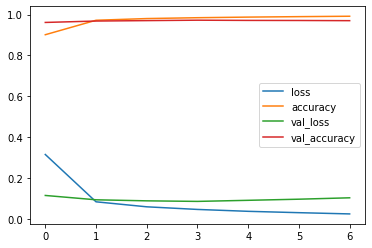

In [22]:
pd.DataFrame(history.history).plot();

In [23]:
# Preprocess the test data and test the model.
X_test = sentence_tokenizer.texts_to_sequences(X_test)
X_test = keras.preprocessing.sequence.pad_sequences(X_test, padding='post', maxlen=CFG.MAX_LENGTH)

y_test = tag_tokenizer.texts_to_sequences(y_test)
y_test = keras.preprocessing.sequence.pad_sequences(y_test, padding='post', maxlen=CFG.MAX_LENGTH)
y_test = keras.utils.to_categorical(y_test)

In [24]:
model.evaluate(X_test, y_test)

226/226 [==============================] - 2s 8ms/step - loss: 0.1044 - accuracy: 0.9701


[0.10438314825296402, 0.9700635075569153]

We can now use our model to tag sentences.

In [34]:
samples = [
    "Brown refused to testify.",
    "Brown sofas are on sale.",
]

The function below takes a list of strings, tokenizes and pads them, then has the model tag them. Note that if a sentence is longer than MAX_LENGTH, it'll be truncated.

In [49]:
def tag_sentences(sentences):
  sentences_seqs   = sentence_tokenizer.texts_to_sequences(sentences)
  sentences_padded = keras.preprocessing.sequence.pad_sequences(sentences_seqs, maxlen=CFG.MAX_LENGTH, padding='post')


  # The model returns a LIST of PROBABILITY DISTRIBUTIONS (due to the softmax)
  # for EACH sentence. There is one probability distribution for each PoS tag.
  tag_preds = model.predict(sentences_padded)

  sentence_tags = []
  for i, preds in enumerate(tag_preds):

    # Most probable tag
    tags_seq = [np.argmax(p) for p in preds[:len(sentences_seqs[i])]]

    # Convert the sentence and tag sequences back to their token counterparts.
    words = [sentence_tokenizer.index_word[w] for w in sentences_seqs[i]]
    tags = [tag_tokenizer.index_word[t] for t in tags_seq]
    sentence_tags.append(list(zip(words, tags)))

  return sentence_tags


In [50]:
tagged_sample_sentences = tag_sentences(samples)

1/1 [==============================] - 0s 36ms/step


In [51]:
tagged_sample_sentences[0]

[('brown', 'noun'), ('refused', 'verb'), ('to', 'prt'), ('testify', 'verb')]

In [52]:
tagged_sample_sentences[1]

[('brown', 'adj'),
 ('sofas', 'noun'),
 ('are', 'verb'),
 ('on', 'adp'),
 ('sale', 'noun')]

So that's one way to build a PoS tagger. Industrial-strength taggers use a lot more data and these days, are powered by more sophisticated models such as Transformers!